# The Bachelier problem

In [1]:
import time

import jax
import codpy.core as core
import matplotlib.pyplot as plt
import numpy as np
import ot
import pandas as pd
import os

from codpy.clustering import *
from codpy.kernel import Kernel
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from scipy.stats import norm

from codpy.kernel import Kernel
from codpy.plot_utils import multi_plot
from codpy.sampling import kernel_conditional_density_estimator


In [5]:
## Base computations for Bachelier problem
def get_basket_values(x, weights, **kwargs): 
    if len(x) == 0: 
        return
    if type(x) is type([]): 
        return [get_basket_values(s,weights,**kwargs) for s in x]
    return np.dot(x, weights)
def get_payoff_values(x, weights, K, **kwargs): 
    if len(x) == 0: 
        return
    if type(x) is type([]): 
        return [get_payoff_values(s,weights,K,**kwargs) for s in x]
    bkt = get_basket_values(x, weights,**kwargs)
    pay = np.maximum(0, bkt - K)
    return np.asarray(pay).reshape(-1,1)
def payoff_nabla_values(x, weights, K, time,**kwargs): 
    if len(x) == 0: 
        return
    if type(x) is type([]): 
        return [payoff_nabla_values(s,weights,K,time,**kwargs) for s in x]
    bkt = get_basket_values(x,weights,**kwargs)
    Z =  np.where(bkt > K, 1.0, 0.0).reshape((-1,1)) * weights.reshape((1,-1))
    return Z

# helper analytics
def BachelierPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return  vol * np.sqrt(T) * norm.pdf(d) + (spot - strike) * norm.cdf(d)

def BachelierDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return norm.cdf(d)

def BachelierVega(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return np.sqrt(T) * norm.pdf(d)

def Bacheliervalues(x, sigma, K, T,weights): 
    return BachelierPrice(get_basket_values(x,weights), K, sigma, T).reshape((-1, 1))

def genCorrel(n,seed = None):
    if (seed): np.random.seed(seed)
    randoms = np.random.uniform(low=-1., high=1., size=(2*n, n))
    cov = randoms.T @ randoms
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])

def get_weights(n,seed = None):
    if (seed): np.random.seed(seed)
    weights = np.random.uniform(low=1., high=10., size=n)
    weights /= np.sum(weights)
    return weights
def genVols(n,seed = None):
    if (seed): 
        np.random.seed(seed)
    return np.random.uniform(low=5., high = 50., size = n)

def get_correlation(d, weights, vols, TargetVol=0.2, seed=None,**kwargs): 
    #random correls, but normalization to bktvol
    corrs = genCorrel(d,seed)
    diagv = np.diag(vols)
    cov = np.linalg.multi_dot([diagv, corrs, diagv])
    correlation = np.linalg.cholesky(cov)
    tempvol = np.sqrt(np.linalg.multi_dot([weights.T, cov, weights]))
    cov *= TargetVol * TargetVol / ( tempvol * tempvol)
    correlation *= TargetVol / tempvol
    testvol = np.sqrt(np.linalg.multi_dot([weights.T, cov, weights])) 
    print("basket vol = ",testvol)
    return correlation

def get_variables(time, x0, corrs,**kwargs): 
    normals = np.random.normal(size=(x0.shape[0] ,x0.shape[1]))
    inc = np.sqrt(time) * normals @ corrs.T
    x1 = x0 + inc
    return np.asarray(x1)

def run_experiment(Nxs, Ds,get_predictors,labels,file_name=None,vol=0.2,K=0.,T=1.,**kwargs):

    def one_experiment(X1,X2,Z,P,ground_truth,get_predictor,**kwargs):
        elapsed_time = time.time()
        values = get_predictor(X1,X2,Z,P,**kwargs)
        elapsed_time = time.time()-elapsed_time
        rmse = RMSEerror_perc(values,ground_truth)
        print("error : ",rmse)
        return rmse,elapsed_time

    results = []
    for Nx in Nxs:
        for D in Ds:
            weights =get_weights(D)
            vols=genVols(D)
            corrs=get_correlation(D,TargetVol=vol,weights=weights,vols=vols,seed=40)
            X0 = np.zeros([Nx, D])
            # X0 = np.random.normal(size=(Nx ,D))
            Z = get_variables(time=T,x0=X0,corrs=corrs,seed=41)
            X1 = get_variables(time=T,x0=X0,corrs=corrs,seed=42)
            X2 = get_variables(time=T,x0=X1,corrs=corrs,seed=43)
            X1 -= np.mean(X1,axis=0)
            X2 -= np.mean(X2,axis=0)

            Z=X1 #test
            ground_truth = Bacheliervalues(Z,vol, K, T,weights)
            payoff_values = get_payoff_values(X2, weights,K)

            # Z,payoff_values,ground_truth=X1,X2,X1 #test on Y

            for get_predictor,label in zip(get_predictors,labels):
                score,elapsed_time = one_experiment(X1,X2,Z,payoff_values,ground_truth,get_predictor,**kwargs)
                # score,elapsed_time = one_experiment(X1,X2,X1,X2,X1,get_predictor,**kwargs)
                print("Method:",label,", Nx:",Nx, ", D:", D, "score:",score," time:",elapsed_time)
                results.append(
                    {
                        "Method": label,
                        "Nx": Nx,
                        "D": D,
                        "time (s)": elapsed_time,
                        "score": score
                    }
        )
    out =   pd.DataFrame(results)
    print(out)
    if file_name is not None: 
        out.to_csv(file_name,index=False)
    return out


def get_results():
    # path = os.path.join(fig_path,"results_MNISTYY.csv")
    path = "Bachelier.csv"
    return pd.read_csv(path)

    
def plot_results(file_name,**kwargs):
    def plot_helper(data, ax, legend="", **kwargs):
        results, col = data
        D,results = results[0],results[1]
        methods = results["Method"].unique()
        Nys = [int(n) for n in results["Nx"].unique()]
        vals,methods = [],[]
        for group in results.groupby("Method")[col]:
            vals.append ( [float(v) for v in group[1]] )
            methods.append(group[0])
        xlims = kwargs.get("xlims",None)
        ylims = kwargs.get("ylims",None)
        if xlims is not None and col in xlims.keys(): ax.set_xlim(xlims[col])
        if ylims is not None and col in ylims.keys(): ax.set_ylim(ylims[col])
        vals = np.array(vals).T
        # ax.loglog(Nys,vals,label=methods)
        ax.plot(Nys,vals,label=methods)
        plt.xlabel('Nx')
        plt.ylabel(col)
        ax.legend()
    results = pd.read_csv(file_name)
    datas = [(x,"score") for x in results.groupby("D")]
    multi_plot(
        datas,
        plot_helper,
        mp_nrows=1,
        mp_ncols=len(datas),
        mp_figsize=(14, 4),
        **kwargs
    )
    datas = [(x,"time (s)") for x in results.groupby("D")]
    multi_plot(
        datas,
        plot_helper,
        mp_nrows=1,
        mp_ncols=len(datas),
        mp_figsize=(14, 4),
        **kwargs
    )
def RMSEerror_perc(X,Y):
    err = np.square(X-Y).sum()*.5
    err /= (np.square(X).sum()+np.square(Y).sum())
    return err

def POT(X,Y,Z,P,**kwargs):
    def OT_0(X,Y,epsilon=None,**kwargs):
        n = X.shape[0]
        a = np.ones(n)
        b = np.ones(n)
        M = ot.dist(X,Y)
        # G0 = ot.bregman.sinkhorn2(a,b,M,1e-3*X.shape[0])
        # G0 = ot.bregman.sinkhorn_log(a,b,M,1e-3)
        G0 = ot.bregman.sinkhorn_epsilon_scaling(a,b,M,1e-3)
        # G0 = ot.bregman.sinkhorn(a,b,M,1e-3)
        # G0 = ot.bregman.greenkhorn(a,b,M,1e-3)
        # G0 = ot.emd(a,b,M)
        return G0

    print("error POT before: ",RMSEerror_perc(X,Y))
    out = OT_0(X,Y,**kwargs)
    print("error POT after: ",RMSEerror_perc(X,out @ Y))
    k = KernelClassifier(x=X,fx=out,**kwargs)
    out = lalg.prod(k(Z),P)
    return out


def OTT(X, Y, Z, P, max_iters=1000,**kwargs):
    # the point cloud geometry
    N = X.shape[0]
    geom = pointcloud.PointCloud(X, Y)
    print("error OTT before: ",RMSEerror_perc(X,Y))
    # solution of the OT problem
    problem = linear_problem.LinearProblem(geom)
    out = jax.numpy.asarray(sinkhorn.Sinkhorn(max_iterations=max_iters)(problem).matrix)*N
    print("error OTT after: ",RMSEerror_perc(X,out @ Y))
    out = Kernel(x=X,fx = out @ P, **kwargs)(Z)
    # out = out @ P
    return out

def dumb(X,Y,Z,P,**kwargs):
    k = Kernel(x=X,fx=np.identity(X.shape[0]),**kwargs)
    out = k(Z) @ P
    return out

def NadarayaWatson(X,Y,Z,P,**kwargs):
    # k = Kernel(x=X,y=Y,**kwargs)
    print("error NadarayaWatson before: ",RMSEerror_perc(X,Y))
    out = kernel_conditional_density_estimator(X,Y,iter=100)
    print("error NadarayaWatson after: ",RMSEerror_perc(X,lalg.prod(out,Y)))
    out = Kernel(x=X,fx = out @ P, **kwargs)(Z)
    return out


def COT(X,Y,Z,P,**kwargs):
    # k = Kernel(**kwargs).set(x=X,y=Y)
    print("error COT before: ",RMSEerror_perc(X,Y))
    out=alg.Pi(x = X, y=Y)    
    print("error COT after: ",RMSEerror_perc(X,lalg.prod(out,Y)))
    out = Kernel(x=X,fx = out @ P, **kwargs)(Z)
    return out


get_predictors = [
    lambda X,Y,Z,P,**k: dumb(X,Y,Z,P,**k),
    lambda X,Y,Z,P,**k: NadarayaWatson(X,Y,Z,P,**k),
    lambda X,Y,Z,P,**k: OTT(X,Y,Z,P,**k),
    lambda X,Y,Z,P,**k: COT(X,Y,Z,P,**k),
]


In [6]:
labels=["ref.","NadarayaWatson","OTT","COT"]

core.kernel_interface.set_verbose()
Nxs = [2**i for i in np.arange(5, 13, 1)]
Ds = [2, 10, 100]
run_experiment(Nxs, Ds,get_predictors,labels,file_name=os.path.join("figs_data", "Bachelier.csv"))

basket vol =  0.20000000000000004
error :  0.13797085211887025
Method: ref. , Nx: 32 , D: 2 score: 0.13797085211887025  time: 0.0022106170654296875
error NadarayaWatson before:  0.14179167421195246
error NadarayaWatson after:  0.10685116924112129
error :  0.0707466329675185
Method: NadarayaWatson , Nx: 32 , D: 2 score: 0.0707466329675185  time: 0.00403594970703125
error OTT before:  0.14179167421195246
error OTT after:  0.03688130184336555
error :  0.04852991168394318
Method: OTT , Nx: 32 , D: 2 score: 0.04852991168394318  time: 0.557981014251709
error COT before:  0.14179167421195246
error COT after:  1.9275601478956907e-06
error :  0.024177851764809376
Method: COT , Nx: 32 , D: 2 score: 0.024177851764809376  time: 0.0030095577239990234
basket vol =  0.2
error :  0.14848470445883175
Method: ref. , Nx: 32 , D: 10 score: 0.14848470445883175  time: 0.0009996891021728516
error NadarayaWatson before:  0.18757334570591858
error NadarayaWatson after:  0.15871009823869625
error :  0.108054136

,Method,Nx,D,time (s),score
0,ref.,32,2,0.002211,0.137971
1,NadarayaWatson,32,2,0.004036,0.070747
2,OTT,32,2,0.557981,0.048530
3,COT,32,2,0.003010,0.024178
4,ref.,32,10,0.001000,0.148485
...,...,...,...,...,...
91,COT,4096,10,26.085258,0.031842
92,ref.,4096,100,6.471271,0.127335
93,NadarayaWatson,4096,100,7.478977,0.144265
94,OTT,4096,100,8.613365,0.084685


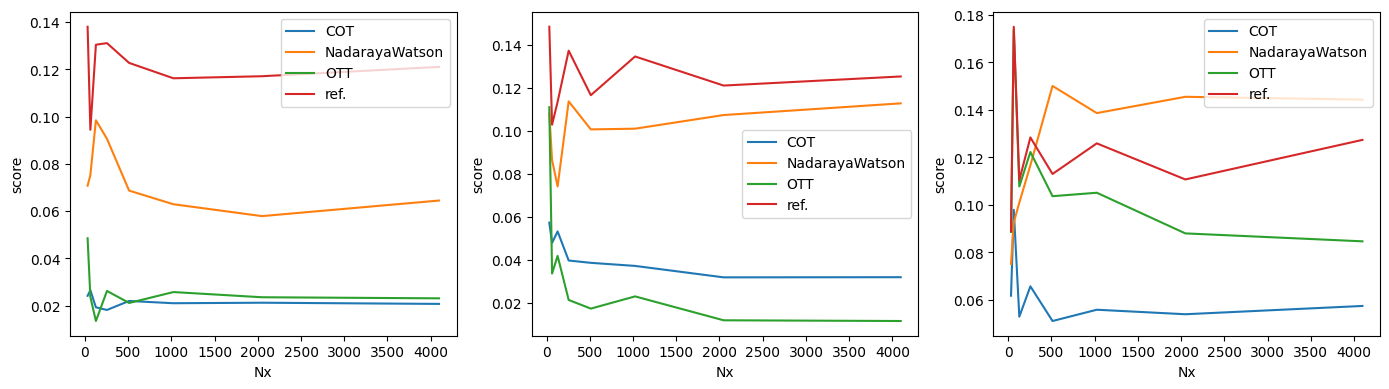

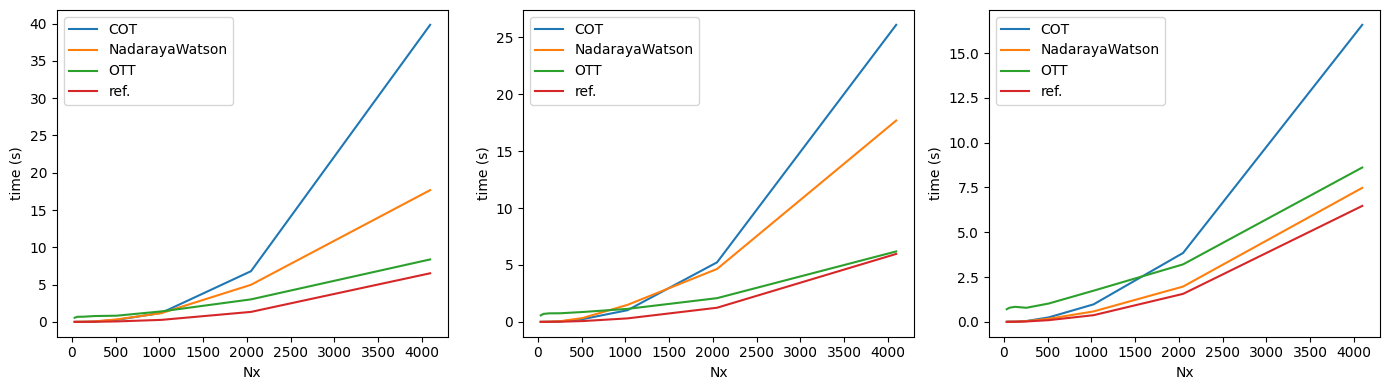

In [7]:
plot_results(file_name=os.path.join("figs_data", "Bachelier.csv"))
plt.show()